# Simple Object Detector for Geometric Objects

## create dataset 

In [2]:
from PIL import Image, ImageDraw
import numpy as np
import csv
import os

def create_data(num,img_dir,label_file):
    width, height = 100,100
    background_color = (0, 0, 0)
    with open(label_file,'w',newline='') as csvfile:
        writer = csv.writer(csvfile)
        #writer.writerow(['filename', 'Image Class','has_circle','num_objects'])
        writer.writerow(['filename','has_circle'])

        for i in range(num):
            img_name =f'image_{i}.png'
            img_path = os.path.join(img_dir,img_name)
            img = Image.new('RGB', (width, height), background_color)
            draw = ImageDraw.Draw(img)
            num_objects = np.random.randint(0, 4)
            has_circle = False
            shapes = []
            for j in range(num_objects):
                shape = np.random.choice(['circle', 'square','rectangle'],p = [0.5,0.25,0.25])
                color = tuple(np.random.randint(0, 256, size=3))
                x1, y1 = np.random.randint(0, width), np.random.randint(0, height)
                x2, y2 = np.random.randint(0, width), np.random.randint(0, height)
                if shape == 'circle':
                    has_circle = True
                    r = np.random.randint(10, 40)
                    draw.ellipse((x1-r, y1-r, x1+r, y1+r), fill=None,outline = color,width = 3)

                elif shape == 'square':
                    s = np.random.randint(10, 50)
                    draw.rectangle((x1, y1, x1+s, y1+s), fill=None,outline = color,width = 3)

                elif shape =='rectangle':
                    a, b = np.random.randint(10,50,size = 2)
                    draw.rectangle((x1 ,y1, x2+a, y2+b),fill = None,outline =color,width =3)
                shapes.append(shape)

            img.save(img_path,quality = 95)
            writer.writerow([img_name, int(has_circle)])

In [2]:
#create Training dataset for 2000
create_data(2000, './dataset/images/','./dataset/labels/labels.csv')

In [3]:
#create Test dataset for 200
create_data(200,'./dataset/test/image/', './dataset/test/labels.csv')

## generate  dataset

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def generate_data(input_path,output_path):
    data = pd.read_csv(input_path)
    image_filenames = data['filename']
    image_classes = data['has_circle']

    image_size = (100,100)
    images = []
    for filename in image_filenames:
        image_path = output_path+filename
        
        image = Image.open(image_path).resize(image_size)
        image = np.array(image)/255.0
        images.append(image)
    images = np.array(images)

    label_encoder = LabelEncoder()
    encoded_classes = label_encoder.fit_transform(image_classes)
    labels = to_categorical(encoded_classes)
    return images, labels

In [5]:
# generate Training data 
training_images,training_labels = generate_data('./dataset/labels/labels.csv','./dataset/images/')

In [6]:
## generate Test data 
test_images,test_labels  = generate_data('./dataset/test/labels.csv','./dataset/test/image/')

## build  CNN model

In [5]:
model = keras.Sequential([
    keras.layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (100,100,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,(3,3),activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
  
    keras.layers.Dense(2,activation = 'sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 33856)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                

In [8]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics = ['accuracy'])

Epoch 1/30
63/63 [==============================] - 14s 205ms/step - loss: 0.5165 - accuracy: 0.7985 - val_loss: 0.3699 - val_accuracy: 0.8400
Epoch 2/30
63/63 [==============================] - 13s 206ms/step - loss: 0.1685 - accuracy: 0.9595 - val_loss: 0.0452 - val_accuracy: 0.9850
Epoch 3/30
63/63 [==============================] - 13s 207ms/step - loss: 0.0265 - accuracy: 0.9930 - val_loss: 0.0244 - val_accuracy: 0.9900
Epoch 4/30
63/63 [==============================] - 13s 208ms/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.0593 - val_accuracy: 0.9750
Epoch 5/30
63/63 [==============================] - 14s 223ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.0321 - val_accuracy: 0.9850
Epoch 6/30
63/63 [==============================] - 16s 246ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.0337 - val_accuracy: 0.9900
Epoch 7/30
63/63 [==============================] - 15s 244ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0438 - val_accuracy: 0.9850

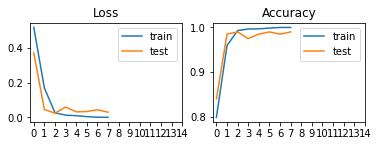

In [9]:
# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# fit model
history = model.fit(training_images, training_labels, validation_data=(test_images, test_labels), epochs=30, callbacks=[early_stopping])
# evaluate the model
_, train_acc = model.evaluate(training_images, training_labels, verbose=0)
_, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


plt.subplot(221)
plt.title('Loss')
plt.plot(history.history['loss'], label='train',)
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xticks(range(15), range(15))

plt.subplot(222)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.xticks(range(15), range(15))
plt.show()

## model evaluation

In [16]:
print(predictions_labels[82])


1


In [17]:
predictions 
print(predictions[82])

[0.31649947 0.65778714]


7/7 [==============================] - 1s 54ms/step
 accuracy： 0.99


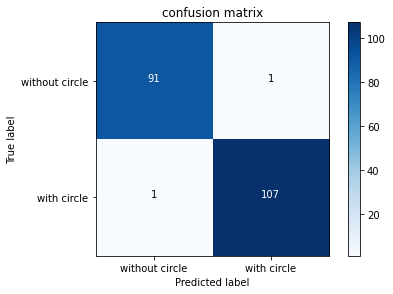

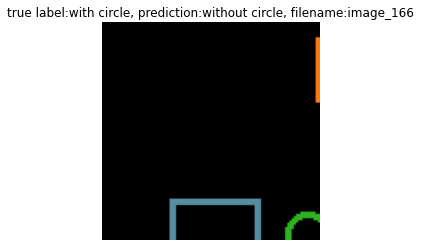

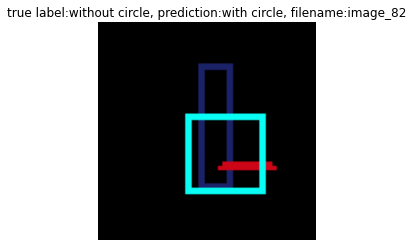

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

true_labels = pd.read_csv('./dataset/test/labels.csv')
label_encoder = LabelEncoder()
true_labels  = label_encoder.fit_transform(true_labels['has_circle'])
predictions = model.predict(test_images)
predictions_labels = np.argmax(predictions , axis=1)
accuracy = np.sum(predictions_labels == true_labels) / len(true_labels)
print(" accuracy：", accuracy)

#Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predictions_labels)

# Visualize the confusion matrix
classes = ['without circle','with circle' ]
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Display values on a heatmap
thresh = confusion.max() / 2
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion[i, j], 'd'), horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

num_samples = 10
sample_indices = np.random.choice(len(predictions), len(predictions), replace=False)
for idx in sample_indices:
    image = test_images[idx]  
    prediction = classes[predictions_labels[idx]]
    true_label = classes[true_labels[idx]]
    if prediction != true_label:
        plt.imshow(image)
        plt.title(f"true label:{true_label}, prediction:{prediction}, filename:image_{idx}")
        plt.axis('off')
        plt.show()


# create a video

In [11]:
import cv2
import numpy as np

In [12]:
width,height = 640,480
fps = 30
duration = 15

output = 'circle_move.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(output,fourcc,fps,(width,height))

r = 40
x = width // 2
y = height // 2
speed = 1

background = np.zeros((height,width,3),dtype = np.uint8)

for frame in range(fps*duration):
    angle = frame*speed *np.pi*2/fps
    circle_x = int(x+r*np.cos(angle))
    circle_y = int(y + r* np.sin(angle))
    
    frame = background.copy()
    cv2.circle(frame,(circle_x,circle_y),r,(255,255,255),-1)
    
    video.write(frame)
    speed += 0.1
video.release()
print("Video wurde erstellt:", output)

Video wurde erstellt: circle_move.mp4
